### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

### Load data

In [3]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH', 'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI', 'UMC','ANET','EPAM', 'UI','XM',
'GIB','TRMB', 'TYL','WIX','HPE','LYFT', 'LOGI', 'MPWR']
top10tech = top100tech[:10]

In [4]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [5]:
data = get_data_yf(top_energy, time_period)

[*********************100%***********************]  25 of 25 completed


In [6]:
data.isna().sum().sum()

0

In [7]:
data = process_stock_data_from_yf(data)

In [8]:
has_data_ratio, data = filter_has_all_data(data)

### Compute technical indicators

In [9]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Choose features

In [10]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize the data within each year, because the stock will tend to have different averages in different years
3. We will want to normalize each different company differently, because the stocks will be of differing magnitudes

In [11]:
sc = RobustScaler()
dataset[features] = sc.fit_transform(dataset[features])

### Train test split

In [12]:
train = dataset.loc[dataset['Date'] < "2020-03-13"]
test = dataset.loc[dataset['Date'] > "2020-03-13"]

#### Prepare training inputs and outputs

In [13]:
x_train, y_train = roll_all_stocks(train, trail_size, predict_length)

In [14]:
x_test, y_test = roll_all_stocks(test, trail_size, predict_length)

#### Confirm shapes

In [15]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (30550, 14, 29)
y_train: (30550,)
x_test: (5950, 14, 29)
y_test (5950,)


### Model design

In [16]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            31500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [18]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train on many stocks

In [20]:
history1 = model.fit(x_train, y_train, epochs=45, validation_data=(x_test, y_test), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/45
478/478 [==============================] - 11s 14ms/step - loss: 0.0820 - val_loss: 0.0789
Epoch 2/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0948 - val_loss: 0.0429
Epoch 3/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0537 - val_loss: 0.0383
Epoch 4/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0390 - val_loss: 0.0293
Epoch 5/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0323 - val_loss: 0.0295
Epoch 6/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0323 - val_loss: 0.0324
Epoch 7/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0323 - val_loss: 0.0295
Epoch 8/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0310 - val_loss: 0.0484
Epoch 9/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0343 - val_loss: 0.0628
Epoch 10/45
478/478 [==============================] - 4s 9ms/step - loss: 0.0321 - val_loss: 0.02

### Prepare data for one stock

In [21]:
single_stock_dataset = dataset[dataset['Ticker']=='XOM'].reset_index(drop=True)

<AxesSubplot:xlabel='Date', ylabel='Close'>

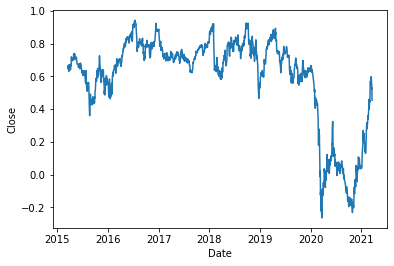

In [22]:
sns.lineplot(x=single_stock_dataset['Date'], y=single_stock_dataset['Close'])

### Train test split

In [23]:
train = single_stock_dataset.loc[single_stock_dataset['Date'] < "2020-03-13"]
test = single_stock_dataset.loc[single_stock_dataset['Date'] > "2020-03-13"]

#### Prepare training inputs and outputs

In [24]:
x_train, y_train = roll_all_stocks(train, trail_size, predict_length)

In [25]:
x_test, y_test = roll_all_stocks(test, trail_size, predict_length)

#### Confirm shapes

In [26]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape)) 

x_train: (1222, 14, 29)
y_train: (1222,)
x_test: (238, 14, 29)
y_test (238,)


### Test model on single stock

In [27]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), 
                                                      y_train,
                                                     num_features,
                                                     sc)))

Training RMSE = 2.550222130179873


In [28]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), 
                                                     y_test,
                                                    num_features,
                                                    sc)))

Testing RMSE = 5.374597172459372


In [29]:
model.layers[7].trainable = False
model.layers[4].trainable = False
model.layers[2].trainable = False
model.layers[0].trainable = False

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            31500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [31]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model on single stock

In [32]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [33]:
history2 = model.fit(x_train, y_train, epochs=45, validation_data=(x_test, y_test), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/45
20/20 [==============================] - 7s 194ms/step - loss: 0.0060 - val_loss: 0.0198
Epoch 2/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0198
Epoch 3/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0198
Epoch 4/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0198
Epoch 5/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0198
Epoch 6/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0198
Epoch 7/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0198
Epoch 8/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0198
Epoch 9/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0198
Epoch 10/45
20/20 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0198
Epoch 11/45
20/20

### Visualize results

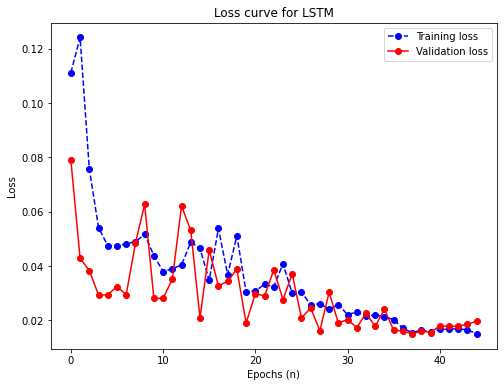

In [34]:
plot_loss(history1)

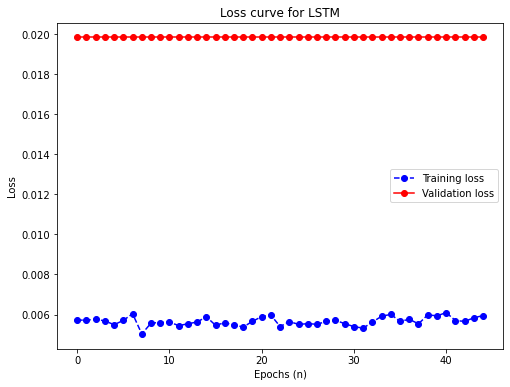

In [35]:
plot_loss(history2)

In [36]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), 
                                                      y_train,
                                                     num_features,
                                                     sc)))

Training RMSE = 2.550222130179873


In [37]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), 
                                                     y_test,
                                                    num_features,
                                                    sc)))

Testing RMSE = 5.374597172459372


#### Compare to simple baseline

In [38]:
def predict_no_change(x):
    return x[-1][0]

In [39]:
no_change_preds = np.array([predict_no_change(x) for x in x_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [40]:
evaluate_model_rmse(no_change_preds, y_train, num_features, sc)

1.8659608978714646

In [41]:
no_change_preds = np.array([predict_no_change(x) for x in x_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [42]:
evaluate_model_rmse(no_change_preds, y_test, num_features, sc)

2.4673554045954575

### Plot data against predictions

<AxesSubplot:title={'center':'Training performance'}>

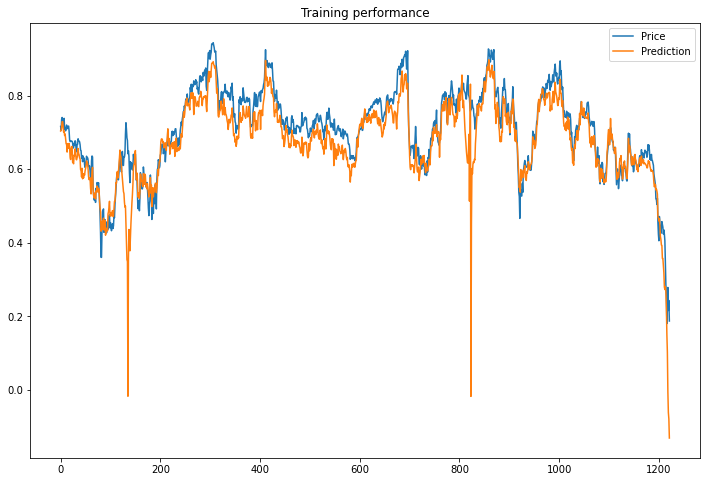

In [43]:
price_vs_preds = pd.DataFrame([x_train[:, -1, 0], model.predict(x_train)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Training performance")

<AxesSubplot:title={'center':'Testing performance'}>

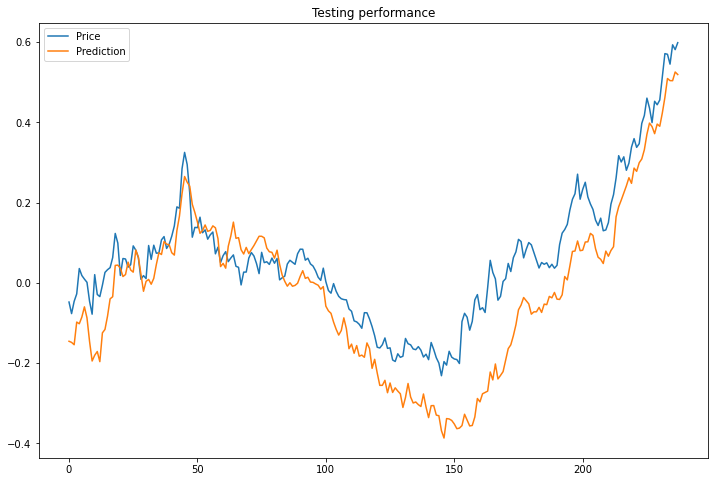

In [44]:
price_vs_preds = pd.DataFrame([x_test[:, -1, 0], model.predict(x_test)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Testing performance")